In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import glob 
import os 

import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_score
from matplotlib import colormaps
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import joblib




In [2]:
def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        elif month in [9, 10, 11]:
            return 'Fall'
        else:
            return np.nan

## Load data 

In [3]:
base_root = "residential/processed"

# Choose interval: "60min" or "15min"
interval = "60min"
load_fname = f"data_pivot_{interval}.csv"
temp_fname = f"temperature_pivot_{interval}.csv"

site_data = {}
total_sites = 0

# Iterate over all states (directories) under base_root
for state_path in glob.glob(os.path.join(base_root, "*")):
    if not os.path.isdir(state_path):
        continue
    state = os.path.basename(state_path)
    print(f"\nProcessing state: {state}")

    state_count = 0

    # Iterate over sites in this state
    for site_path in glob.glob(os.path.join(state_path, "*")):
        if not os.path.isdir(site_path):
            continue

        site_id = os.path.basename(site_path)
        load_path = os.path.join(site_path, "loads", load_fname)
        temp_path = os.path.join(site_path, "temps", temp_fname)
        weather_path = os.path.join(site_path, "weather", "weather_station.csv")

        # Only include sites that have load data
        if os.path.exists(load_path):
            try:
                load_df = pd.read_csv(load_path)
            except Exception as e:
                print(f"  ! Skipping {state}/{site_id}: failed to read loads ({e})")
                continue

            temp_df = None
            if os.path.exists(temp_path):
                try:
                    temp_df = pd.read_csv(temp_path)
                except Exception as e:
                    print(f"  ! Warning: could not read temps for {state}/{site_id} ({e})")

            weather_df = None
            if os.path.exists(weather_path):
                try:
                    weather_df = pd.read_csv(weather_path)
                except Exception as e:
                    print(f"  ! Warning: could not read weather for {state}/{site_id} ({e})")

            # Use a composite key to avoid collisions across states
            key = f"{state}/{site_id}"
            site_data[key] = {
                "site_id": site_id,
                "state": state,
                "load": load_df,
                "temp": temp_df,
                "weather": weather_df,
            }

            state_count += 1
            total_sites += 1
            print(f"  ✓ Loaded {state}/{site_id}")

    print(f"Loaded {state_count} sites from state {state}")

print(f"\nTotal sites loaded across all states: {total_sites}")


Processing state: MT
  ✓ Loaded MT/5896
  ✓ Loaded MT/5231
  ✓ Loaded MT/6281
  ✓ Loaded MT/5486
  ✓ Loaded MT/5091
  ✓ Loaded MT/5126
  ✓ Loaded MT/6176
  ✓ Loaded MT/5791
Loaded 8 sites from state MT

Processing state: ID
  ✓ Loaded ID/2071
  ✓ Loaded ID/241484
  ✓ Loaded ID/2616
  ✓ Loaded ID/216927
  ✓ Loaded ID/10037
  ✓ Loaded ID/2476
  ✓ Loaded ID/238591
  ✓ Loaded ID/315991
  ✓ Loaded ID/363743
  ✓ Loaded ID/292998
  ✓ Loaded ID/248624
  ✓ Loaded ID/339735
  ✓ Loaded ID/2561
  ✓ Loaded ID/10118
  ✓ Loaded ID/651751
  ✓ Loaded ID/298259
  ✓ Loaded ID/295578
  ✓ Loaded ID/2331
  ✓ Loaded ID/322328
  ✓ Loaded ID/307473
  ✓ Loaded ID/312138
  ✓ Loaded ID/2581
  ✓ Loaded ID/3001
  ✓ Loaded ID/306108
  ✓ Loaded ID/10023
  ✓ Loaded ID/2651
  ✓ Loaded ID/2091
  ✓ Loaded ID/2641
  ✓ Loaded ID/2026
  ✓ Loaded ID/225734
  ✓ Loaded ID/2086
  ✓ Loaded ID/10239
  ✓ Loaded ID/268535
  ✓ Loaded ID/2846
  ✓ Loaded ID/285144
  ✓ Loaded ID/281519
  ✓ Loaded ID/101860
  ✓ Loaded ID/2956
  ✓ Loade

## Create variables:

In [4]:
def get_avg_hourly_load(df:pd.DataFrame) -> pd.Series:
    hourly_load = df.groupby(['date', 'hour'])['total_kW'].sum().mean()
    
    return float(hourly_load)

avg_loads = [get_avg_hourly_load(data_dict['load']) for data_dict in site_data.values()]

print(len(avg_loads))

243


In [5]:
def get_load_factor(df:pd.DataFrame, avg_daily_load:float) -> float:
    peak_load = df.groupby('date')['total_kW'].max()
    peak_load = peak_load.mean()

    load_factor = avg_daily_load / peak_load
    return float(load_factor)

load_factors = [get_load_factor(data_dict['load'], avg) for data_dict, avg in zip(site_data.values(), avg_loads)]

print(load_factors)


[0.26535418175512177, 0.6342607917020596, 0.4256798649315212, 0.5494757412779728, 0.47032300484777645, 0.3544180959578126, 0.4612341160385109, 0.25723293491304583, 0.25900194134496174, 0.2564535422133045, 0.43768796553775025, 0.33656859930375516, 0.27674584354622733, 0.2895598285502172, 0.31929369174783173, 0.2695523969717952, 0.32464885886973344, 0.2952045476630066, 0.503517046764956, 0.29105555115755183, 0.43253320836559644, 0.2630500490371572, 0.43986302813420103, 0.5030303690427043, 0.2429350014290591, 0.27791872652083727, 0.43552980157049587, 0.6144295064846511, 0.35543781442400146, 0.2575495419717585, 0.41688279922358706, 0.3555942893137928, 0.13008624475696823, 0.3774570879680986, 0.3747191020006408, 0.5197720977152087, 0.3902623183844442, 0.09764989222281514, 0.3140646675619725, 0.3319010218137018, 0.40204700089913287, 0.4289006344305426, 0.1724128386114571, 0.342096590333646, 0.23418185573327696, 0.42851202882883815, 0.46604137790708716, 0.48199745188370335, 0.3956414340958851

/var/folders/gg/mxqdv6zd0s92c5zxnm3bwb100000gn/T/ipykernel_27545/2372026134.py:5: RuntimeWarning: invalid value encountered in scalar divide
  load_factor = avg_daily_load / peak_load
/var/folders/gg/mxqdv6zd0s92c5zxnm3bwb100000gn/T/ipykernel_27545/2372026134.py:5: RuntimeWarning: invalid value encountered in scalar divide
  load_factor = avg_daily_load / peak_load


In [6]:
def get_hvac_fraction(df:pd.DataFrame):
    hvac = df['hvac_total_kW'].sum()
    total = df['total_kW'].sum()
    fraction = hvac / total
    return float(fraction)

hvac_fractions = [get_hvac_fraction(data_dict['load']) for data_dict in site_data.values()]
print(hvac_fractions)


[0.3141384766650771, 0.07987852745350812, 0.059652704658703586, 0.9031878071129806, 0.700447263083814, 0.2666450216803362, 0.5033269182060823, 0.11366033217877745, 0.730079111440538, 0.24625916870415648, 0.18853746512397973, 0.41957885707966075, 0.7648012401052324, 0.4308664952648746, 0.260653183440574, 0.15522979739645396, 0.32954098331600334, 0.683365427344097, 0.34550057375449217, 0.039588928090345865, 0.2271994021716027, 0.7000599341856878, 0.7685079154162175, 0.3030943957581375, 0.34659212454707533, 0.048417073707017415, 0.10354481616287839, 0.008374131586418199, 0.17750169310623368, 0.6952297095253679, 0.34391020941190764, 0.1938137045196338, 1.4362191929222714, 0.11422616546462731, 0.17855577028129718, 0.5176976902632977, 0.4342033390331424, 1.5930954626069371, 0.20321418119250167, 0.6041192959171418, 0.3309125739240269, 0.2554801987013789, 0.0022752625940202576, 0.24041678139008785, 0.579597234836368, 0.056939394439325705, 0.21392816079497487, 0.04935014809173364, 0.33216763972

/var/folders/gg/mxqdv6zd0s92c5zxnm3bwb100000gn/T/ipykernel_27545/3280271852.py:4: RuntimeWarning: invalid value encountered in scalar divide
  fraction = hvac / total


In [7]:
def day_vs_night_ratio(df:pd.DataFrame) -> float:
    day_load = df[(df['hour'] >= 7) & (df['hour'] < 19)]['total_kW'].sum()
    night_load = df[(df['hour'] < 7) | (df['hour'] >= 19)]['total_kW'].sum()
    ratio = day_load / night_load
    return float(ratio)

day_night_ratios = [day_vs_night_ratio(data_dict['load']) for data_dict in site_data.values()]
print(day_night_ratios)


/var/folders/gg/mxqdv6zd0s92c5zxnm3bwb100000gn/T/ipykernel_27545/521978434.py:4: RuntimeWarning: invalid value encountered in scalar divide
  ratio = day_load / night_load


[1.209416851318723, 1.0726586684968937, 1.065580054425512, 0.7257371649524309, 1.099896067019636, 1.419772046254002, 1.1981258525705152, 1.141136939819678, 1.1465732405638762, 0.5394459500150558, 1.2627168181321646, 1.3177623019592823, 1.163058238272229, 1.1863759088557029, 1.2335018265632287, 1.4434795574527572, 1.0514685118054217, 0.934741212958776, 0.8498283827250229, 1.0542943341602304, 1.0124112297653391, 0.48708321051587716, 1.1654551754389197, 1.2301472379922755, 0.6577327474591063, 1.817110662287412, 1.284561498301387, 1.1654874031457336, 1.1024397112337079, 1.9801464605666166, 1.3040968243914672, 1.0678206755989648, 0.16331743977306218, 2.3597366857408986, 1.5827820571173117, 1.0302219745238161, 1.1724639085090238, -0.49043765259869015, 1.0310184855494782, 1.4688698402469742, 1.248330520716237, 1.573225734715403, 1.3952908495651308, 0.7019106392198756, 1.1522625485003029, 1.5081247972875826, 1.0002927284047605, 1.4160960765134225, 1.24278942953721, 1.1391831190806228, 1.223782

In [8]:
def seasonal_std_variation(df:pd.DataFrame) -> float:
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month
    df['season'] = df['month'].apply(get_season)
    
    seasonal_mean = df.groupby('season')['total_kW'].mean()
    std_between_seasons = seasonal_mean.std()


    return std_between_seasons

seasonal_std_devs = [seasonal_std_variation(data_dict['load']) for data_dict in site_data.values()]
print(seasonal_std_devs)


[0.043998766329310976, 0.6637864340486443, 0.5595197693579131, 1.5971787486765923, 1.3701372608901161, 0.06000219923929191, 0.45151354474594085, 0.13868423403655575, 1.082702320007847, 0.22585383246961027, 0.29121025008032575, 0.30907659683752864, 0.28667287485358744, 0.19331518004498588, 0.3056227001614017, 0.4312174886720216, 0.16568102044731556, 0.28430470352220755, 4.511208242246252, 0.47277505674269865, 1.2002958455586552, 0.30955943853550116, 1.0812221116854452, 0.3928718592347898, 0.2699037120598367, 0.40428618515871967, 1.7203763373548038, 0.24327811703657598, 0.27565314087712434, 1.0885452398907294, 0.5081354731983219, 0.4012539160388639, 0.21317896757624194, 0.12920606482070837, 0.3184999215309287, 0.6601626245936115, 0.3240192776885984, 0.3598969790803453, 0.08646577127530887, 0.2433644245317325, 0.1926227874385226, 0.8268750106046567, 0.10765362034108757, 0.22559013167323877, 0.18693810121838947, 0.6766477512208666, 0.29864538067180774, 0.41948508338048457, 0.56226717837379

In [9]:
def weekday_vs_weekend_consumption(df : pd.DataFrame):
    weekday = df[df['is_weekend']==0]
    weekend = df[df['is_weekend']==1]

    weekday = weekday.groupby('hour')['total_kW'].sum().mean()
    weekend = weekend.groupby('hour')['total_kW'].sum().mean()
    

    return float(weekday/weekend)

weekday_vs_weekend = [weekday_vs_weekend_consumption(data_dict['load']) for data_dict in site_data.values()]
print(weekday_vs_weekend)




/var/folders/gg/mxqdv6zd0s92c5zxnm3bwb100000gn/T/ipykernel_27545/3832873204.py:9: RuntimeWarning: invalid value encountered in scalar divide
  return float(weekday/weekend)


[2.3962823625522045, 2.4755650564242755, 2.3400808106253708, 2.492563886256384, 2.381615202146283, 2.6141056736389836, 2.3217987112879337, 2.116245219978447, 2.6712185487188194, 3.146529859349781, 2.558020295876532, 2.5763043198944984, 2.230904321772467, 2.374695377607537, 2.536274250193098, 2.1085146656678786, 2.3901075130986524, 3.17541713625993, 2.4731642520588766, 2.642258265270571, 2.3130626905555784, 2.396085694561181, 2.5974140095405476, 2.342620559374508, 2.299380693501608, 2.427024585751032, 2.3727637069419347, 2.565093058284061, 2.630012290170488, 2.5842160299855497, 2.7058693348272227, 2.450817521004437, 2.008096139039923, 2.4897891711975095, 2.419493716594913, 2.503526243198923, 2.3262221733511996, 1.43254774723381, 2.4839388783862724, 2.4392332818111737, 2.2051247927470627, 2.461442392306521, 3.00969884853853, 2.289496126056808, 2.303266359988384, 2.598249690442854, 2.74905330917169, 2.5498331924451283, 2.386597799961713, 2.5142276004288004, 2.6715961260651793, 2.486332665

In [10]:
def temp_hvac_regression(df: pd.DataFrame, weather_df: pd.DataFrame):
    weather_df['min_t'] = pd.to_datetime(weather_df['min_t'])
    weather_df['max_t'] = pd.to_datetime(weather_df['max_t'])

    # Option 1: Use start time's hour
    weather_df['hour'] = weather_df['min_t'].dt.hour


    # Option 2: Use the midpoint between start and end times
    weather_df['mid_t'] = weather_df['min_t'] + (weather_df['max_t'] - weather_df['min_t']) / 2
    weather_df['hour_mid'] = weather_df['mid_t'].dt.hour
    weather_df['date'] = weather_df['mid_t'].dt.date
        
    
    df['date'] = pd.to_datetime(df['date']).dt.date


    weather_df = weather_df.groupby('date')['temp'].mean().reset_index()


    df = df.groupby(['season','date'])['hvac_total_kW'].mean().reset_index()

    df_weather_merged = pd.merge(
        df,
        weather_df[['temp','date']],
        on='date',
        how='left'
    )

    summer = df_weather_merged[df_weather_merged['season'] =='Summer']  
    winter = df_weather_merged[df_weather_merged['season'] =='Winter']

    # Summer linear regression - ensure same shape by dropping NaN together
    summer_clean = summer[['temp', 'hvac_total_kW']].dropna()
    summer_clean = summer_clean[summer_clean['hvac_total_kW'] > 0]
    X_summer = summer_clean[['temp']]
    y_summer = summer_clean['hvac_total_kW']
    


    model = LinearRegression(fit_intercept=True)
    model.fit(X_summer, y_summer)
    y_pred = model.predict(X_summer)
    mse = mean_squared_error(y_summer, y_pred)
    r2 = r2_score(y_summer, y_pred)
    
    coefs_summer = model.coef_
    if model.fit_intercept:
        
        summer_intercept = model.intercept_
    else:
        summer_intercept = 0
        
    
    

    # Winter linear regression - ensure same shape by dropping NaN together
    winter_clean = winter[['temp', 'hvac_total_kW']].dropna()
    winter_clean = winter_clean[winter_clean['hvac_total_kW'] > 0]
    X_winter = winter_clean[['temp']]
    y_winter = winter_clean['hvac_total_kW']
    
    
    model_winter = LinearRegression(fit_intercept=True)
    model_winter.fit(X_winter, y_winter)
    y_pred_winter = model_winter.predict(X_winter)
    mse_winter = mean_squared_error(y_winter, y_pred_winter)
    r2_winter = r2_score(y_winter, y_pred_winter)


   
    coefs_winter = model_winter.coef_
    if model.fit_intercept:
        
        winter_intercept = model.intercept_

    else:
        winter_intercept = 0
    
    
    

    summary_df = pd.DataFrame({
        'Season': ['Summer', 'Winter'],
        'Coefficient': [coefs_summer[0], coefs_winter[0]],
        'Intercept': [summer_intercept, winter_intercept],
        'MSE': [mse, mse_winter],
        'R-squared': [r2, r2_winter]
    })

    return summary_df


regression_df = temp_hvac_regression(load_df,weather_df)

print(regression_df.round(3))

   Season  Coefficient  Intercept    MSE  R-squared
0  Summer        0.014     -0.171  0.015      0.163
1  Winter       -0.058     -0.171  0.010      0.821


## Clustering: 

In [11]:
keys = list(site_data.keys())

training_df = pd.DataFrame({
    'Site_id': keys,
    'avg_daily_load_kW': avg_loads,
    'load_factor': load_factors,
    'hvac_fraction': hvac_fractions,
    'day_vs_night_ratio': day_night_ratios,
    'seasonal_std': seasonal_std_devs,
    'weekend_vs_weekday_ratio': weekday_vs_weekend,
    'hvac/temperature regression summer coef': [regression_df['Coefficient'][0] for _ in keys],
    'hvac/temperature regression winter coef': [regression_df['Coefficient'][1] for _ in keys],
    'hvac regression summer R-squared': [regression_df['R-squared'][0] for _ in keys],
    'hvac regression winter R-squared': [regression_df['R-squared'][1] for _ in keys],
    'state': [site_data[k]['state'] for k in keys]   
})

training_df.head(-5)

,Site_id,avg_daily_load_kW,load_factor,hvac_fraction,day_vs_night_ratio,seasonal_std,weekend_vs_weekday_ratio,hvac/temperature regression summer coef,hvac/temperature regression winter coef,hvac regression summer R-squared,hvac regression winter R-squared,state
0,MT/5896,0.442622,0.265354,0.314138,1.209417,0.043999,2.396282,0.013763,-0.057681,0.163135,0.821141,MT
1,MT/5231,2.930486,0.634261,0.079879,1.072659,0.663786,2.475565,0.013763,-0.057681,0.163135,0.821141,MT
2,MT/6281,1.038725,0.425680,0.059653,1.065580,0.559520,2.340081,0.013763,-0.057681,0.163135,0.821141,MT
3,MT/5486,4.141394,0.549476,0.903188,0.725737,1.597179,2.492564,0.013763,-0.057681,0.163135,0.821141,MT
4,MT/5091,2.440806,0.470323,0.700447,1.099896,1.370137,2.381615,0.013763,-0.057681,0.163135,0.821141,MT
...,...,...,...,...,...,...,...,...,...,...,...,...
233,WA/11101,0.673584,0.352452,0.331753,1.306002,0.061022,2.604595,0.013763,-0.057681,0.163135,0.821141,WA
234,WA/191005,1.295374,0.325193,0.357740,1.243522,0.466102,2.481965,0.013763,-0.057681,0.163135,0.821141,WA
235,WA/10481,2.526439,0.490923,0.578105,1.065187,0.621636,2.427307,0.013763,-0.057681,0.163135,0.821141,WA
236,WA/9421,1.417450,0.254802,0.114991,1.710993,0.354822,2.580694,0.013763,-0.057681,0.163135,0.821141,WA


In [12]:
features = ['avg_daily_load_kW', 'load_factor', 'hvac_fraction',
            'day_vs_night_ratio', 'seasonal_std', 'weekend_vs_weekday_ratio','hvac/temperature regression summer coef','hvac/temperature regression winter coef',''
            'hvac regression summer R-squared','hvac regression winter R-squared','state']

X = training_df[features]

In [13]:

# Columns / basic validation
features_num = [
    'avg_daily_load_kW', 'load_factor', 'hvac_fraction',
    'day_vs_night_ratio', 'seasonal_std', 'weekend_vs_weekday_ratio','hvac/temperature regression summer coef','hvac/temperature regression winter coef',''
    'hvac regression summer R-squared','hvac regression winter R-squared'
]

feature_cat = 'state'

w_state = 0.4  # tune 0.1–0.5

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),   # <-- handle NaNs
    ('scaler', StandardScaler())
])

def weight_block(X, w=0.4):
    return X * w


cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='UNK')),  # <-- fill missing state
    ('onehot', OneHotEncoder( handle_unknown='ignore')),
    ('weight', FunctionTransformer(weight_block, kw_args={'w': w_state}, feature_names_out='one-to-one'))
])


preprocess = ColumnTransformer(
    transformers=[
        ('num', num_transformer, features_num),
        ('cat', cat_transformer, [feature_cat])
    ],
    remainder='drop'
)

X_proc = preprocess.fit_transform(training_df)

# Optional: sanity check
if np.isnan(X_proc).any():
    raise RuntimeError("NaNs still present after preprocessing – check inputs.")

# Helper to get output feature names
def get_out_feature_names(preprocess, features_num, feature_cat):
    names = []
    names.extend(features_num)  # numeric preserved by our pipeline
    ohe = preprocess.named_transformers_['cat'].named_steps['onehot']
    names.extend(ohe.get_feature_names_out([feature_cat]).tolist())  # e.g., ['state_CA', ...]
    return names

feature_names_out = get_out_feature_names(preprocess, features_num, feature_cat)





## KMeans:


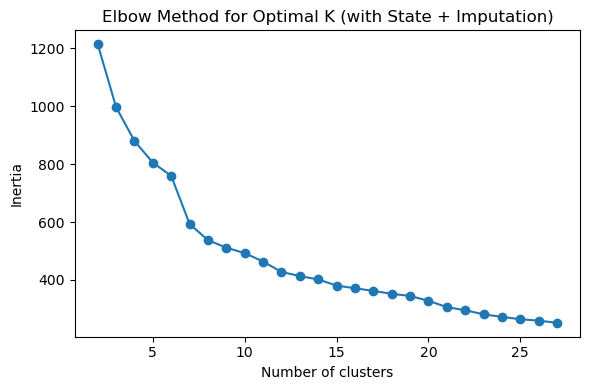

In [14]:

# Elbow + KMeans
inertias = []
K_range = range(2, 28)
for k in K_range:
    kmeans_tmp = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans_tmp.fit(X_proc)
    inertias.append(kmeans_tmp.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertias, 'o-')
plt.title('Elbow Method for Optimal K (with State + Imputation)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.tight_layout()
plt.show()


In [20]:
num_clusters = 7
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
training_df['cluster'] = kmeans.fit_predict(X_proc)


kmeans_pipeline = Pipeline(steps=[
    ('preprocess', preprocess),  #  ColumnTransformer from the cell above
    ('model', kmeans) #kmeans model
])
kmeans_pipeline.fit(training_df)

# 3) Persist the pipeline (single file) + tiny metadata

joblib.dump(kmeans_pipeline, 'kmeans_pipeline.joblib')

meta = {
    "features_num": features_num,
    "feature_cat": feature_cat,
    "w_state": w_state,
    "n_clusters": num_clusters
}
joblib.dump(meta, 'kmeans_pipeline.meta.joblib')
print("Saved kmeans_pipeline.joblib and kmeans_pipeline.meta.joblib")




# PCA viz for plotting loadings
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_proc)


Saved kmeans_pipeline.joblib and kmeans_pipeline.meta.joblib


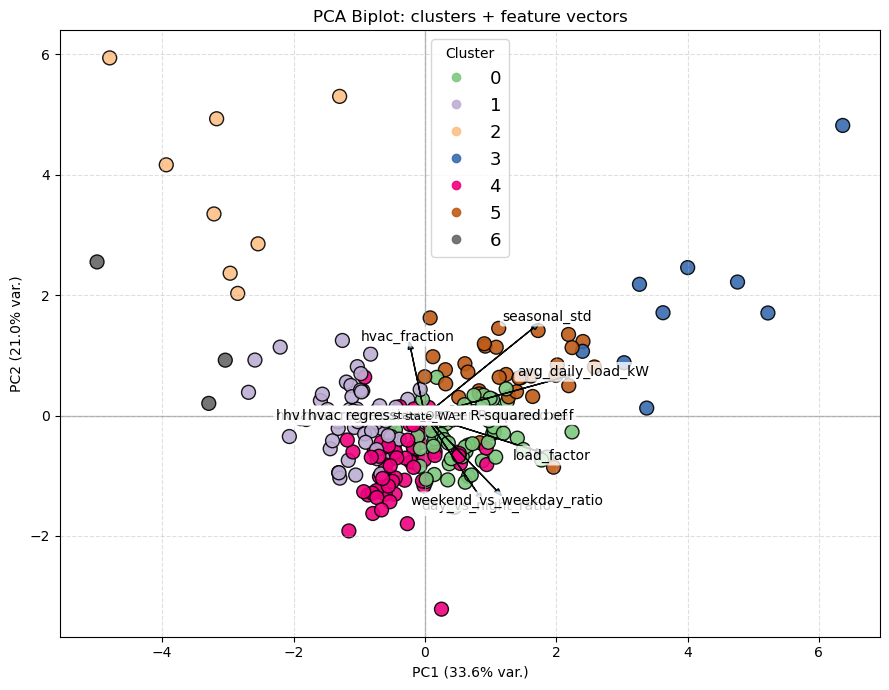


PCA loadings (numeric features):
                                         PC1_loading  PC2_loading
avg_daily_load_kW                              0.878        0.265
load_factor                                    0.703       -0.243
hvac_fraction                                 -0.093        0.477
day_vs_night_ratio                             0.342       -0.549
seasonal_std                                   0.680        0.599
weekend_vs_weekday_ratio                       0.456       -0.519
hvac/temperature regression summer coef        0.000       -0.000
hvac/temperature regression winter coef        0.000        0.000
hvac regression summer R-squared               0.000        0.000
hvac regression winter R-squared               0.000        0.000


In [16]:
include_state_arrows = True  # set True if you really want them

# Loadings matrix (features x PCs), scaled by sqrt(eigvals) for classic biplot
loadings_full = pca.components_.T * np.sqrt(pca.explained_variance_)  # shape: (n_features_proc, 2)

# Figure out which columns in X_proc are numeric vs one-hot(state)
n_num = len(features_num)
num_loadings = loadings_full[:n_num, :]  # first block = numeric features
num_feature_names = features_num

# Optional: state one-hot loadings
state_loadings = None
state_feature_names = []
if include_state_arrows:
    state_cols = [c for c in feature_names_out if c.startswith(f"{feature_cat}_")]
    state_loadings = loadings_full[n_num:n_num + len(state_cols), :]
    state_feature_names = state_cols

# A reasonable arrow scale based on score spread
spread = np.mean([X_pca[:,0].std(), X_pca[:,1].std()])
arrow_scale = 2.0 * spread  # tweak if arrows look too long/short

fig, ax = plt.subplots(figsize=(9,7))

# Scatter points (colored by cluster, as before)
scatter = ax.scatter(X_pca[:,0], X_pca[:,1],
                     c=training_df['cluster'], s=100, cmap='Accent', edgecolor='k', alpha=0.9)

# Draw numeric feature vectors
for i, fname in enumerate(num_feature_names):
    x, y = num_loadings[i,0] * arrow_scale, num_loadings[i,1] * arrow_scale
    ax.arrow(0, 0, x, y, width=0.0, head_width=0.08, length_includes_head=True, alpha=0.95)
    ax.text(x * 1.07, y * 1.07, fname, ha='center', va='center', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='none', alpha=0.8))

# Optionally draw state one-hot arrows (can be many)
if include_state_arrows and state_loadings is not None:
    for i, fname in enumerate(state_feature_names):
        x, y = state_loadings[i,0] * arrow_scale, state_loadings[i,1] * arrow_scale
        ax.arrow(0, 0, x, y, width=0.0, head_width=0.06, length_includes_head=True, alpha=0.5)
        ax.text(x * 1.05, y * 1.05, fname, ha='center', va='center', fontsize=8,
                bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='none', alpha=0.6))

# Axes / labels
evr = pca.explained_variance_ratio_ * 100
ax.set_xlabel(f"PC1 ({evr[0]:.1f}% var.)")
ax.set_ylabel(f"PC2 ({evr[1]:.1f}% var.)")

ax.axhline(0, color='grey', linewidth=1, alpha=0.5)
ax.axvline(0, color='grey', linewidth=1, alpha=0.5)

ax.set_title("PCA Biplot: clusters + feature vectors")
plt.legend(*scatter.legend_elements(), title="Cluster", loc='best', fontsize=13)
ax.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# (Optional) print loadings table for the numeric features
load_tbl = pd.DataFrame(num_loadings, index=num_feature_names, columns=['PC1_loading','PC2_loading'])
print("\nPCA loadings (numeric features):")
print(load_tbl.round(3))



In [17]:
centers = kmeans.cluster_centers_
centers_df = pd.DataFrame(centers, columns=feature_names_out)
centers_df['Cluster'] = range(len(centers_df))


# Inverse-transform numeric part back to original units
num_scaler = preprocess.named_transformers_['num'].named_steps['scaler']
# Get the original feature names for numeric part and inverse transform
num_cols = features_num
state_cols = [c for c in centers_df.columns if c.startswith(f'{feature_cat}_')]
num_block_scaled = centers_df[num_cols].to_numpy()
num_block_orig = num_scaler.inverse_transform(num_block_scaled)
centers_num_inv = pd.DataFrame(num_block_orig, columns=[f"{c} (orig)" for c in num_cols])

# Unweight state block to get prevalence (mean 0/1)
centers_state_weighted = centers_df[state_cols].copy()
centers_state_prev = centers_state_weighted / w_state 
centers_state_prev = centers_state_prev.clip(0, 1)

cluster_summary = pd.concat([centers_df[['Cluster']], centers_num_inv, centers_state_prev], axis=1)
print("\nCluster centers (numeric back to original units; state_* ≈ prevalence):")
print(cluster_summary.round(3))




Cluster centers (numeric back to original units; state_* ≈ prevalence):
   Cluster  avg_daily_load_kW (orig)  load_factor (orig)  \
0        0                     1.692               0.469   
1        1                     0.877               0.311   
2        2                     0.289               0.111   
3        3                     4.804               0.442   
4        4                     0.973               0.312   
5        5                     2.190               0.385   
6        6                    -0.242              -0.158   

   hvac_fraction (orig)  day_vs_night_ratio (orig)  seasonal_std (orig)  \
0                 0.278                      1.138                0.458   
1                 0.318                      1.151                0.223   
2                 1.574                     -0.285                0.692   
3                 0.267                      1.196                2.061   
4                 0.358                      1.581                0.317

Dummy Site Characteristics:
     Site_id  avg_daily_load_kW  load_factor  hvac_fraction  \
0  DUMMY_001                4.5         0.35            0.6   

   day_vs_night_ratio  seasonal_std  weekend_vs_weekday_ratio  \
0                 1.8           1.2                       0.9   

   hvac/temperature regression summer coef  \
0                                     0.25   

   hvac/temperature regression winter coef  hvac regression summer R-squared  \
0                                     0.15                               0.7   

   hvac regression winter R-squared state  
0                               0.5    WA  

Dummy site would be assigned to: Cluster 5

Characteristics of Cluster 5:
   Cluster  avg_daily_load_kW (orig)  load_factor (orig)  \
5        5                      2.19               0.385   

   hvac_fraction (orig)  day_vs_night_ratio (orig)  seasonal_std (orig)  \
5                 0.464                      1.301                1.072   

   weekend_vs_weekday_rat

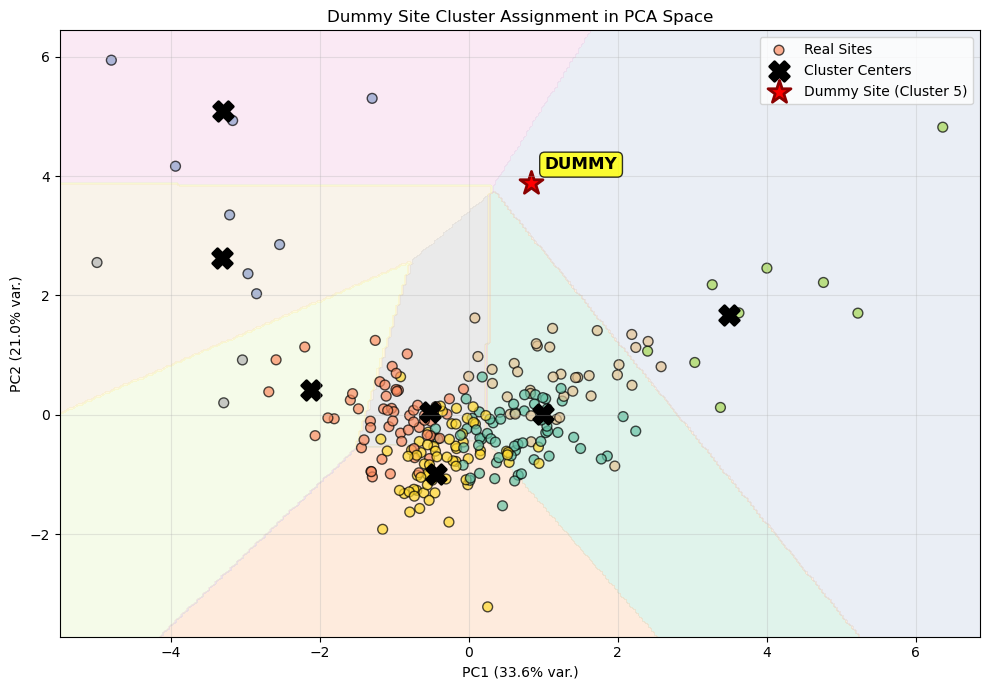

In [18]:
# Create a dummy site with specific characteristics
dummy_site = pd.DataFrame({
    'Site_id': ['DUMMY_001'],
    'avg_daily_load_kW': [4.5],          # Medium average load
    'load_factor': [0.35],               # Moderate load factor (peaks vs average)
    'hvac_fraction': [0.6],              # 60% HVAC usage (heating/cooling dominant)
    'day_vs_night_ratio': [1.8],         # More daytime usage than nighttime
    'seasonal_std': [1.2],               # Some seasonal variation
    'weekend_vs_weekday_ratio': [0.9],   # Slightly less usage on weekends
    'hvac/temperature regression summer coef': [0.25],  # Moderate sensitivity to temperature in summer
    'hvac/temperature regression winter coef': [0.15],  # Lower sensitivity in winter
    'hvac regression summer R-squared': [0.7],          # Good fit in summer
    'hvac regression winter R-squared': [0.5],
    'state': ['WA']                      # Washington state
})

print("Dummy Site Characteristics:")
print(dummy_site.round(3))

cluster_pipe = joblib.load('kmeans_pipeline.joblib')
dummy_processed = cluster_pipe.named_steps['preprocess'].transform(dummy_site)

# Predict which cluster this dummy site belongs to
predicted_cluster= cluster_pipe.predict(dummy_site)[0]

print(f"\nDummy site would be assigned to: Cluster {predicted_cluster}")

# Show the characteristics of this cluster
print(f"\nCharacteristics of Cluster {predicted_cluster}:")
cluster_row = cluster_summary[cluster_summary['Cluster'] == predicted_cluster]
print(cluster_row.round(3))


# Compare dummy site to cluster center
print(f"\nComparison: Dummy Site vs Cluster {predicted_cluster} Center")
comparison_df = pd.DataFrame({
    'Feature': features_num,
    'Dummy_Site': [dummy_site[col].iloc[0] for col in features_num],
    'Cluster_Center': [cluster_row[f"{col} (orig)"].iloc[0] for col in features_num],
})
comparison_df['Difference'] = comparison_df['Dummy_Site'] - comparison_df['Cluster_Center']
print(comparison_df.round(3))

# Visualize dummy site on PCA plot
dummy_pca = pca.transform(dummy_processed)

# Create grid for decision boundaries - use the PCA-space kmeans for visualization
x_min, x_max = X_pca[:, 0].min() - 0.5, X_pca[:, 0].max() + 0.5
y_min, y_max = X_pca[:, 1].min() - 0.5, X_pca[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

# For visualization, we need to use a kmeans fitted on PCA space
kmeans_pca = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
kmeans_pca.fit(X_pca)
Z = kmeans_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 7))

# Background shading by cluster (optional)
plt.contourf(xx, yy, Z, cmap="Pastel2", alpha=0.4)


# Plot existing sites
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], 
                     c=training_df['cluster'], s=50, cmap='Set2', 
                     edgecolor='k', alpha=0.7, label='Real Sites')

# Plot cluster centers (in PCA space)
centers_pca = kmeans_pca.cluster_centers_
plt.scatter(centers_pca[:, 0], centers_pca[:, 1],
           c='black', s=200, marker='X', label='Cluster Centers', linewidth=2)

# Plot dummy site
plt.scatter(dummy_pca[0, 0], dummy_pca[0, 1], 
           c='red', s=300, marker='*', 
           label=f'Dummy Site (Cluster {predicted_cluster})', 
           edgecolor='darkred', linewidth=2)

# Add annotation for dummy site
plt.annotate('DUMMY', 
            (dummy_pca[0, 0], dummy_pca[0, 1]), 
            xytext=(10, 10), textcoords='offset points',
            fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.8))



evr = pca.explained_variance_ratio_ * 100
plt.xlabel(f"PC1 ({evr[0]:.1f}% var.)")
plt.ylabel(f"PC2 ({evr[1]:.1f}% var.)")
plt.title("Dummy Site Cluster Assignment in PCA Space")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



In [19]:

def save_state_averages(training_df, features_num, filename='state_averages.csv'):
    """
    Simple function to calculate and save state averages as CSV.
    """
    state_stats = []
    
    for state in training_df['state'].unique():
        state_sites = training_df[training_df['state'] == state]
        
        state_avg = {
            'state': state,
            'site_count': len(state_sites)
        }
        
        # Add average for each feature
        for feature in features_num:
            state_avg[f'avg_{feature}'] = state_sites[feature].mean()
        
        state_stats.append(state_avg)
    
    # Save as CSV
    state_df = pd.DataFrame(state_stats)
    state_df.to_csv(filename, index=False)
    print(f" State averages saved to: {filename}")
    
    return state_df



# Create and save state averages
state_averages = save_state_averages(training_df, features_num)

print("\nState Summary:")
print(state_averages.round(3))



 State averages saved to: state_averages.csv

State Summary:
  state  site_count  avg_avg_daily_load_kW  avg_load_factor  \
0    MT           8                  1.735            0.427   
1    ID          62                  1.411            0.354   
2    OR          87                  1.206            0.337   
3    WA          86                  1.615            0.367   

   avg_hvac_fraction  avg_day_vs_night_ratio  avg_seasonal_std  \
0              0.368                   1.117             0.611   
1              0.370                   1.184             0.609   
2              0.379                   1.189             0.411   
3              0.333                   1.230             0.576   

   avg_weekend_vs_weekday_ratio  avg_hvac/temperature regression summer coef  \
0                         2.392                                        0.014   
1                         2.482                                        0.014   
2                         2.366                     

## Affinity Propagation :

AffinityPropagation: found 34 clusters
Silhouette (AP): 0.139


/var/folders/gg/mxqdv6zd0s92c5zxnm3bwb100000gn/T/ipykernel_72686/944501445.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('Set2', n)


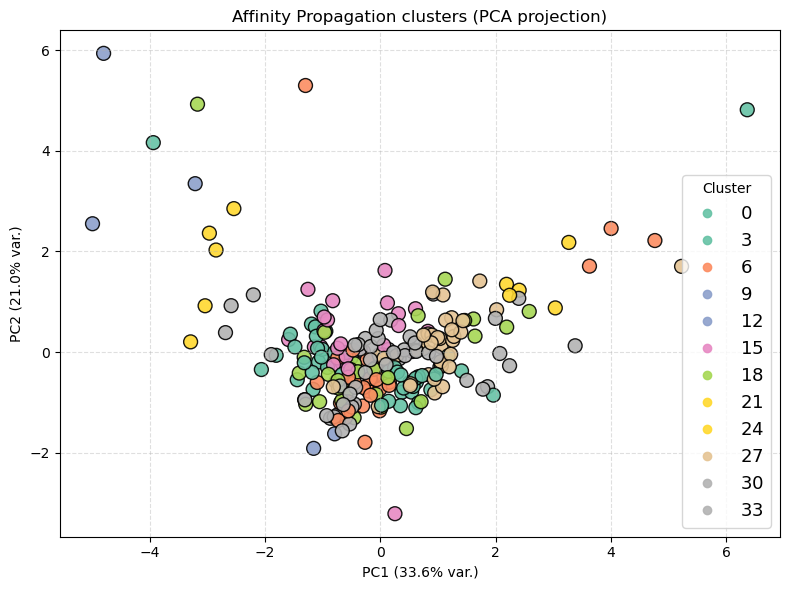

In [44]:
import matplotlib as mpl
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_score

#  1) Fit Affinity Propagation 

ap = AffinityPropagation(random_state=42, damping=0.9)  # default affinity='euclidean'
labels_aff = ap.fit_predict(X_proc)
training_df['cluster_aff'] = labels_aff

n_aff = len(np.unique(labels_aff))
print(f"AffinityPropagation: found {n_aff} clusters")

# Optional quality metric (silhouette)
if n_aff >= 2:
    sil = silhouette_score(X_proc, labels_aff)
    print(f"Silhouette (AP): {sil:.3f}")

# 2) PCA scatter colored by AP labels 
try:
    X_pca
except NameError:
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_proc)

uniq = np.sort(np.unique(labels_aff))
label_map = {old:i for i, old in enumerate(uniq)}          # make labels consecutive 0..n-1 for plotting
labels_plot = np.array([label_map[l] for l in labels_aff])
n = len(uniq)

cmap = mpl.cm.get_cmap('Set2', n)
norm = mpl.colors.BoundaryNorm(np.arange(-0.5, n + 0.5, 1), cmap.N)

fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(X_pca[:,0], X_pca[:,1],
                c=labels_plot, cmap=cmap, norm=norm,
                s=100, edgecolor='k', alpha=0.9)

evr = pca.explained_variance_ratio_ * 100
ax.set_xlabel(f"PC1 ({evr[0]:.1f}% var.)")
ax.set_ylabel(f"PC2 ({evr[1]:.1f}% var.)")
ax.set_title("Affinity Propagation clusters (PCA projection)")
ax.grid(True, linestyle='--', alpha=0.4)

plt.legend(*sc.legend_elements(), title="Cluster", loc='best', fontsize=13)
plt.tight_layout()
plt.show()


In [45]:
# ========= Save Affinity Propagation Pipeline =========

# Since AffinityPropagation doesn't have a standard predict method for new data,
# we need to create a custom pipeline that can find the closest exemplar

class AffinityPropagationPredictor:
    """
    Custom class to handle predictions for Affinity Propagation clustering.
    Since AP doesn't have a built-in predict method, this class finds the closest exemplar.
    """
    def __init__(self, preprocessor, ap_model, training_data_processed, cluster_labels):
        self.preprocessor = preprocessor
        self.ap_model = ap_model
        self.training_data_processed = training_data_processed
        self.cluster_labels = cluster_labels
        self.exemplar_indices = ap_model.cluster_centers_indices_
        self.exemplar_data = training_data_processed[self.exemplar_indices]
        
    def predict(self, X_new):
        """
        Predict cluster for new data by finding closest exemplar
        """
        # Preprocess the new data
        X_processed = self.preprocessor.transform(X_new)
        
        predictions = []
        for sample in X_processed:
            # Calculate distances to all exemplars
            distances = []
            for i, exemplar in enumerate(self.exemplar_data):
                dist = np.linalg.norm(sample - exemplar)
                distances.append((dist, self.exemplar_indices[i]))
            
            # Find closest exemplar
            closest_dist, closest_exemplar_idx = min(distances)
            
            # Get cluster label of closest exemplar
            predicted_cluster = self.cluster_labels[closest_exemplar_idx]
            predictions.append(predicted_cluster)
            
        return np.array(predictions)
    
    def predict_with_details(self, X_new):
        """
        Predict cluster and return additional details about the prediction
        """
        X_processed = self.preprocessor.transform(X_new)
        
        results = []
        for sample in X_processed:
            # Calculate distances to all exemplars
            distances = []
            for i, exemplar in enumerate(self.exemplar_data):
                dist = np.linalg.norm(sample - exemplar)
                exemplar_site_idx = self.exemplar_indices[i]
                cluster_label = self.cluster_labels[exemplar_site_idx]
                distances.append((dist, exemplar_site_idx, cluster_label, i))
            
            # Sort by distance
            distances.sort(key=lambda x: x[0])
            
            # Get prediction details
            closest_dist, closest_exemplar_site_idx, predicted_cluster, closest_exemplar_idx = distances[0]
            
            result = {
                'predicted_cluster': predicted_cluster,
                'closest_exemplar_site_idx': closest_exemplar_site_idx,
                'closest_exemplar_idx': closest_exemplar_idx,
                'distance_to_exemplar': closest_dist,
                'all_distances': distances[:5]  # Top 5 closest exemplars
            }
            results.append(result)
            
        return results

# Create the custom predictor
ap_predictor = AffinityPropagationPredictor(
    preprocessor=preprocess,
    ap_model=ap,
    training_data_processed=X_proc,
    cluster_labels=labels_aff
)

# Save the predictor and metadata
joblib.dump(ap_predictor, 'affinity_propagation_predictor.joblib')

# Save metadata
ap_meta = {
    "features_num": features_num,
    "feature_cat": feature_cat,
    "w_state": w_state,
    "n_clusters": n_aff,
    "exemplar_indices": ap.cluster_centers_indices_.tolist(),
    "silhouette_score": sil if n_aff >= 2 else None,
    "damping": 0.9
}
joblib.dump(ap_meta, 'affinity_propagation_predictor.meta.joblib')

print("Saved affinity_propagation_predictor.joblib and affinity_propagation_predictor.meta.joblib")
print(f"Model contains {n_aff} clusters with {len(ap.cluster_centers_indices_)} exemplars")

# ========= Test the saved model =========
# Load and test the saved predictor
loaded_ap_predictor = joblib.load('affinity_propagation_predictor.joblib')
loaded_ap_meta = joblib.load('affinity_propagation_predictor.meta.joblib')

print(f"\nLoaded model metadata:")
print(f"  Number of clusters: {loaded_ap_meta['n_clusters']}")
print(f"  Features: {loaded_ap_meta['features_num']}")
print(f"  State weighting: {loaded_ap_meta['w_state']}")

# Test with the dummy site from KMeans example
test_prediction = loaded_ap_predictor.predict(dummy_site)
print(f"\nTest prediction for dummy site: Cluster {test_prediction[0]}")

# Test with detailed prediction
detailed_prediction = loaded_ap_predictor.predict_with_details(dummy_site)
print(f"Detailed prediction:")
print(f"  Predicted cluster: {detailed_prediction[0]['predicted_cluster']}")
print(f"  Distance to closest exemplar: {detailed_prediction[0]['distance_to_exemplar']:.3f}")
print(f"  Closest exemplar site index: {detailed_prediction[0]['closest_exemplar_site_idx']}")

Saved affinity_propagation_predictor.joblib and affinity_propagation_predictor.meta.joblib
Model contains 34 clusters with 34 exemplars

Loaded model metadata:
  Number of clusters: 34
  Features: ['avg_daily_load_kW', 'load_factor', 'hvac_fraction', 'day_vs_night_ratio', 'seasonal_std', 'weekend_vs_weekday_ratio', 'hvac/temperature regression summer coef', 'hvac/temperature regression winter coef', 'hvac regression summer R-squared', 'hvac regression winter R-squared']
  State weighting: 0.4

Test prediction for dummy site: Cluster 15
Detailed prediction:
  Predicted cluster: 15
  Distance to closest exemplar: 4.551
  Closest exemplar site index: 127


=== Dummy Site Characteristics (Affinity Propagation) ===
        Site_id  avg_daily_load_kW  load_factor  hvac_fraction  \
0  DUMMY_AP_001                3.8         0.42           0.45   

   day_vs_night_ratio  seasonal_std  weekend_vs_weekday_ratio state  
0                 1.4           0.8                       1.1    OR  

Dummy site would be assigned to Cluster: 15
Closest exemplar is site index 127: OR/7481
Distance to closest exemplar: 2.981

Number of sites in Cluster 15: 1

Cluster 15 statistics:
       avg_daily_load_kW  load_factor  hvac_fraction  day_vs_night_ratio  \
count              1.000        1.000          1.000               1.000   
mean               1.708        0.528          0.016               1.066   
std                  NaN          NaN            NaN                 NaN   
min                1.708        0.528          0.016               1.066   
25%                1.708        0.528          0.016               1.066   
50%                1.708      

/var/folders/gg/mxqdv6zd0s92c5zxnm3bwb100000gn/T/ipykernel_43893/1213564422.py:80: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('Set2', n)


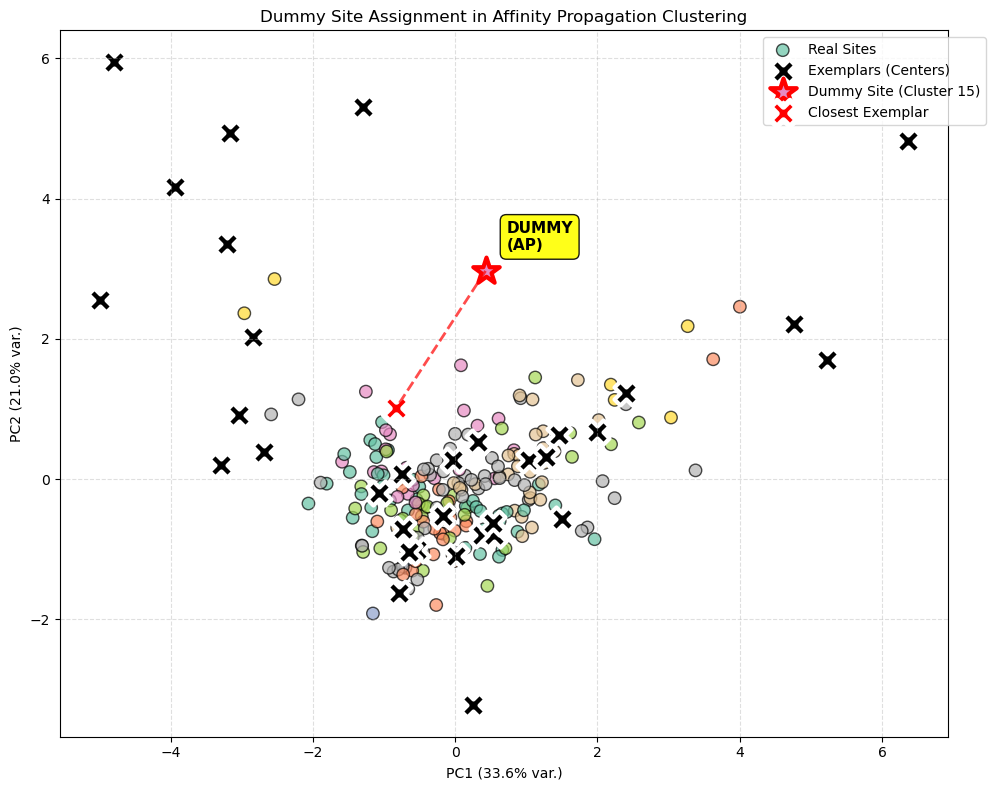


Distance to all exemplars (closest first):
  Rank 1: Cluster 15, Site OR/7481 (OR), Distance: 2.981
  Rank 2: Cluster 12, Site OR/521 (OR), Distance: 4.848
  Rank 3: Cluster 16, Site OR/8236 (OR), Distance: 5.015
  Rank 4: Cluster 33, Site WA/10416 (WA), Distance: 5.110
  Rank 5: Cluster 31, Site WA/395998 (WA), Distance: 5.114

Dummy site is 1.63x closer to its assigned cluster than the next closest


In [ ]:
# ========= Dummy Site Analysis for Affinity Propagation =========

# Create a dummy site with specific characteristics
dummy_site_ap = pd.DataFrame({
    'Site_id': ['DUMMY_AP_001'],
    'avg_daily_load_kW': [3.8],          # Slightly lower than KMeans dummy
    'load_factor': [0.42],               # Higher load factor 
    'hvac_fraction': [0.45],             # Lower HVAC fraction (more electric appliances)
    'day_vs_night_ratio': [1.4],         # More balanced day/night usage
    'seasonal_std': [0.8],               # Less seasonal variation
    'weekend_vs_weekday_ratio': [1.1],   # Slightly more usage on weekends
    'state': ['OR']                      # Oregon state (different from previous dummy)
})

print("=== Dummy Site Characteristics (Affinity Propagation) ===")
print(dummy_site_ap.round(3))

# Preprocess the dummy site using the same pipeline
dummy_processed_ap = preprocess.transform(dummy_site_ap)

# For Affinity Propagation, we need to find the closest exemplar
# AP doesn't have a direct predict method, so we find closest exemplar
exemplar_indices = ap.cluster_centers_indices_
exemplar_data = X_proc[exemplar_indices]

# Calculate distances from dummy site to all exemplars
distances_to_exemplars = []
for i, exemplar in enumerate(exemplar_data):
    dist = np.linalg.norm(dummy_processed_ap - exemplar)
    distances_to_exemplars.append((i, dist, exemplar_indices[i]))

# Sort by distance to find closest exemplar
distances_to_exemplars.sort(key=lambda x: x[1])
closest_exemplar_idx = distances_to_exemplars[0][0]
closest_exemplar_site_idx = distances_to_exemplars[0][2]

# Get the cluster assignment for the dummy site (same as closest exemplar)
dummy_cluster_ap = labels_aff[closest_exemplar_site_idx]

print(f"\nDummy site would be assigned to Cluster: {dummy_cluster_ap}")
print(f"Closest exemplar is site index {closest_exemplar_site_idx}: {training_df.iloc[closest_exemplar_site_idx]['Site_id']}")
print(f"Distance to closest exemplar: {distances_to_exemplars[0][1]:.3f}")

# Show characteristics of sites in this cluster
cluster_sites = training_df[training_df['cluster_aff'] == dummy_cluster_ap]
print(f"\nNumber of sites in Cluster {dummy_cluster_ap}: {len(cluster_sites)}")

# Show cluster statistics
cluster_stats = cluster_sites[features_num].describe()
print(f"\nCluster {dummy_cluster_ap} statistics:")
print(cluster_stats.round(3))

# Compare dummy site to cluster average
cluster_avg = cluster_sites[features_num].mean()
comparison_ap = pd.DataFrame({
    'Feature': features_num,
    'Dummy_Site': [dummy_site_ap[col].iloc[0] for col in features_num],
    'Cluster_Avg': cluster_avg.values,
    'Exemplar': [training_df.iloc[closest_exemplar_site_idx][col] for col in features_num]
})
comparison_ap['Diff_vs_Avg'] = comparison_ap['Dummy_Site'] - comparison_ap['Cluster_Avg']
comparison_ap['Diff_vs_Exemplar'] = comparison_ap['Dummy_Site'] - comparison_ap['Exemplar']

print(f"\nComparison: Dummy Site vs Cluster {dummy_cluster_ap} Average vs Exemplar:")
print(comparison_ap.round(3))

# ========= Visualization =========
# Transform dummy site to PCA space
dummy_pca_ap = pca.transform(dummy_processed_ap)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Use the same color mapping as the AP plot
uniq = np.sort(np.unique(labels_aff))
label_map = {old:i for i, old in enumerate(uniq)}
labels_plot = np.array([label_map[l] for l in labels_aff])
n = len(uniq)

cmap = mpl.cm.get_cmap('Set2', n)
norm = mpl.colors.BoundaryNorm(np.arange(-0.5, n + 0.5, 1), cmap.N)

# Plot all sites
sc = ax.scatter(X_pca[:,0], X_pca[:,1],
                c=labels_plot, cmap=cmap, norm=norm,
                s=80, edgecolor='k', alpha=0.7, label='Real Sites')

# Plot exemplars (cluster centers) - these are actual data points
exemplar_pca = X_pca[exemplar_indices]
ax.scatter(exemplar_pca[:, 0], exemplar_pca[:, 1],
           s=300, marker='X', c='black', linewidth=3, 
           label='Exemplars (Centers)', edgecolor='white')

# Plot the dummy site
dummy_color = label_map[dummy_cluster_ap]
ax.scatter(dummy_pca_ap[0, 0], dummy_pca_ap[0, 1],
           s=400, marker='*', c=[dummy_color], cmap=cmap, norm=norm,
           edgecolor='red', linewidth=3,
           label=f'Dummy Site (Cluster {dummy_cluster_ap})')

# Highlight the closest exemplar
closest_exemplar_pca = X_pca[closest_exemplar_site_idx]
ax.scatter(closest_exemplar_pca[0], closest_exemplar_pca[1],
           s=350, marker='X', c='red', linewidth=4,
           label='Closest Exemplar', edgecolor='white')

# Draw line connecting dummy to closest exemplar
ax.plot([dummy_pca_ap[0, 0], closest_exemplar_pca[0]], 
        [dummy_pca_ap[0, 1], closest_exemplar_pca[1]],
        '--', color='red', linewidth=2, alpha=0.7)

# Add annotation for dummy site
ax.annotate('DUMMY\n(AP)', 
            (dummy_pca_ap[0, 0], dummy_pca_ap[0, 1]), 
            xytext=(15, 15), textcoords='offset points',
            fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.4', fc='yellow', alpha=0.9))

# Labels and formatting
evr = pca.explained_variance_ratio_ * 100
ax.set_xlabel(f"PC1 ({evr[0]:.1f}% var.)")
ax.set_ylabel(f"PC2 ({evr[1]:.1f}% var.)")
ax.set_title("Dummy Site Assignment in Affinity Propagation Clustering")
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(bbox_to_anchor=(1.05, 1), loc='best')

plt.tight_layout()
plt.show()

# ========= Distance Analysis =========
print(f"\nDistance to all exemplars (closest first):")
for i, (ex_idx, dist, site_idx) in enumerate(distances_to_exemplars[:5]):  # Show top 5
    site_id = training_df.iloc[site_idx]['Site_id']
    state = training_df.iloc[site_idx]['state']
    cluster = labels_aff[site_idx]
    print(f"  Rank {i+1}: Cluster {cluster}, Site {site_id} ({state}), Distance: {dist:.3f}")

print(f"\nDummy site is {distances_to_exemplars[1][1]/distances_to_exemplars[0][1]:.2f}x closer to its assigned cluster than the next closest")